In [1]:
%load_ext tensorboard
# %reload_ext tensorboard
import numpy as np
import cv2
import os
from PIL import Image
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from tensorflow.keras.models import load_model

### Take a screenshot through your camera

In [2]:
# camera = cv2.VideoCapture(0)
# return_value, image = camera.read()
# cv2.imwrite('test.png', image)
# del(camera)

### OpenCV Haar Cascade

In [3]:
# Load Haar Cascade object, have to download OpenCV package (https://opencv.org/releases/)
face_cascade = cv2.CascadeClassifier('C:\\opencv\\build\\etc\\haarcascades\\haarcascade_frontalface_default.xml')

In [4]:
# Apply Haar Cascade on the test image
test_img = cv2.imread('test.png')
faces = face_cascade.detectMultiScale(test_img, 1.3, 5)
x, y, w, h = faces[0]
face_img = test_img[y:y+h, x:x+w]

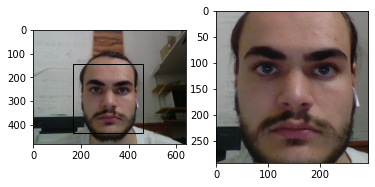

In [5]:
# Plot result
rect = Rectangle((x,y), w, h, fill=False)
fig, ax = plt.subplots(1,2)
ax[0].imshow(cv2.cvtColor(test_img, cv2.COLOR_BGR2RGB))
ax[0].add_patch(rect)
ax[1].imshow(cv2.cvtColor(face_img, cv2.COLOR_BGR2RGB))
plt.show()

In [6]:
cv2.imwrite('face_test.png', face_img)

True

### Apply ML model on test image

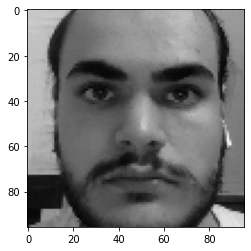

In [7]:
# Adapt test image for our model
gray_img = np.array(cv2.cvtColor(face_img, cv2.COLOR_BGR2GRAY))
# plt.imshow(gray_img)
resized_img_2 = np.resize(gray_img, (96,96))
resized_img = cv2.resize(gray_img, dsize=(96, 96), interpolation=cv2.INTER_CUBIC)
pred_img = np.array(resized_img).reshape((1,96,96))/255
# resized_img = np.array(gray_img.resize((96,96),Image.ANTIALIAS))
plt.imshow(resized_img, cmap='gray')
plt.show()
# plt.imshow(resized_img_2, cmap='gray')
# plt.show()

In [8]:
# Load trained model
fkd_model = load_model('fkd_model_without_inv.h5')

In [9]:
# Make prediction
pred = fkd_model.predict(np.expand_dims(pred_img, axis=3))

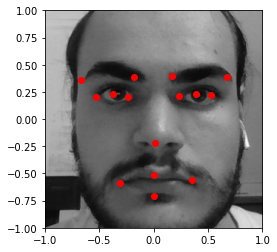

In [10]:
# Plot prediction
plt.imshow(gray_img, cmap='gray', extent=[-1,1,-1,1])
for i in range(0,pred.shape[1],2):
    plt.scatter(pred[0,i], pred[0,i+1], c='r')
plt.savefig('pred_img.png')
plt.show()

### Apply filter on test image

Glasses

In [11]:
# Define glasses's dimensions
glass_left = [165,120]
glass_right = [540,120]
glass_dist = np.sqrt((glass_right[0]-glass_left[0])**2 + (glass_right[1]-glass_left[1])**2)
print(glass_dist)

375.0


In [12]:
# Define glasses's coordinates
cst = np.amin(gray_img.shape)//2
left_eye = [int((48*pred[0,2]+48)*((2*cst)/96)), int((-48*pred[0,3]+48)*((2*cst)/96))]
right_eye = [int((48*pred[0,0]+48)*((2*cst)/96)), int((-48*pred[0,1]+48)*((2*cst)/96))]
face_dist = np.sqrt((right_eye[0]-left_eye[0])**2 + (right_eye[1]-left_eye[1])**2)
print(face_dist)
ratio = face_dist/glass_dist
print(ratio)

111.0
0.296


In [13]:
print(left_eye)
print(right_eye)
print(cst)

[91, 112]
[202, 112]
146


In [14]:
# top left corner glasses
tlc_glass = [int(left_eye[1]-glass_left[1]*ratio), int(left_eye[0]-glass_left[0]*ratio)] 
print(tlc_glass)

[76, 42]


(293, 293, 3)
(79, 215, 4)
79 215


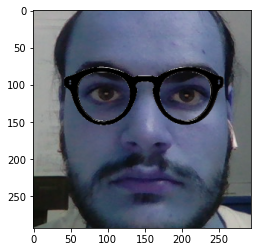

In [15]:
# Plot test image with glasses
glass = cv2.imread('glass.png', -1)

h,w = int(glass.shape[0]*ratio), int(glass.shape[1]*ratio)
img1 = face_img.copy()
img2 = glass.copy()
img2 = cv2.resize(img2, dsize=(w,h), interpolation=cv2.INTER_CUBIC)
print(img1.shape)
print(img2.shape)
print(h,w)
# result = np.zeros((img1.shape[0], img1.shape[1], 3), np.uint8)
result = img1.copy()
alpha = np.expand_dims((img2[:, :, 3] / 255.0),axis=2)
alpha = np.repeat(alpha, 3, axis=2)
result[tlc_glass[0]:h+tlc_glass[0], tlc_glass[1]:w+tlc_glass[1], :3] = (1. - alpha) * img1[tlc_glass[0]:h+tlc_glass[0], tlc_glass[1]:w+tlc_glass[1], :3] + alpha * img2[:, :, :3]
plt.imshow(result)
plt.show()
# cv2.imshow("result", result)
# cv2.waitKey(0)
# cv2.destroyAllWindows()


# 175,130 -> 550,130

Beard

In [16]:
# Define beard's dimensions
beard = cv2.imread('beard.png', -1)
beard_left = [115,160]
beard_right = [350,160]
beard_dist = np.sqrt((beard_right[0]-beard_left[0])**2 + (beard_right[1]-beard_left[1])**2)
print(beard_dist)

235.0


### Apply filters in live through laptop camera

In [17]:
def draw(image, result, pred, img_coord, img_dist, cst):
    left_el = [int((48*pred[2]+48)*((2*cst)/96)), int((-48*pred[3]+48)*((2*cst)/96))]
    right_el = [int((48*pred[0]+48)*((2*cst)/96)), int((-48*pred[1]+48)*((2*cst)/96))]
    dist = np.sqrt((right_el[0]-left_el[0])**2 + (right_el[1]-left_el[1])**2)
    ratio = dist/img_dist
    tlc = [int(left_el[1]-img_coord[1]*ratio), int(left_el[0]-img_coord[0]*ratio)]
    h, w = int(image.shape[0]*ratio), int(image.shape[1]*ratio)
    drawing = cv2.resize(image, dsize=(w,h), interpolation=cv2.INTER_CUBIC)
    alpha = np.expand_dims((drawing[:, :, 3] / 255.0),axis=2)
    alpha = np.repeat(alpha, 3, axis=2)
    result[tlc[0]:h+tlc[0], tlc[1]:w+tlc[1], :3] = (1. - alpha) * result[tlc[0]:h+tlc[0], tlc[1]:w+tlc[1], :3] + alpha * drawing[:, :, :3]
    return result

In [18]:
vid = cv2.VideoCapture(0)
# out = cv2.VideoWriter('output.avi', cv2.VideoWriter_fourcc(*"MJPG"), 20,(640,480))
while True:
    ret, frame = vid.read()
    faces = face_cascade.detectMultiScale(frame, 1.3, 5)
    for x,y,w,h in faces:
        cst=min(w,h)//2
        x_shift, y_shift = (w-2*cst)//2, (h-2*cst)//2
        face_img = frame[y:y+h, x:x+w]
        gray_img = np.array(cv2.cvtColor(face_img, cv2.COLOR_BGR2GRAY))
        resized_img = cv2.resize(gray_img, dsize=(96, 96), interpolation=cv2.INTER_CUBIC)
        pred_img = np.array(resized_img).reshape((1,96,96))/255
        pred = fkd_model.predict(np.expand_dims(pred_img, axis=3))
        
        pred_eye = [pred[0,0], pred[0,1], pred[0,2], pred[0,3]]
        pred_mouth = [pred[0,22],pred[0,23],pred[0,24],pred[0,25]]
        
        result = face_img.copy()
        
        result = draw(glass, result, pred_eye, glass_left, glass_dist, cst)
        result = draw(beard, result, pred_mouth, beard_left, beard_dist, cst)
        
        frame[y:y+h,x:x+w] = result
                      
    cv2.imshow('frame', frame)
    # out.write(frame)
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break
# After the loop release the cap object
vid.release()
# Destroy all the windows
cv2.destroyAllWindows()
# out.release()